<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Aplicaciones Recientes de Redes Neuronales </H3>

<H2 align='center'> Pregunta 1. RNN sobre texto</H2>
<H3 align='center'> Francisca Ramírez</H3>
<H3 align='center'> Sebastian Ramírez</H3>

<hr style="height:2px;border:none"/>



In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed
from sklearn.metrics import f1_score

Using TensorFlow backend.


<a id="primero"></a>
## 1. RNN sobre texto
---

Hoy en dı́a, una aplicación relevante de las redes neuronales recurrentes es el modelamiento de texto y lenguaje natural. En esta sección abordaremos el problema de procesar sentencias de texto, proporcionadas por GMB (*Groningen Meaning Bank*), para reconocimiento de entidades y *tagger*. En específico, trabajaremos con el dataset proprocionado a través de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__, que está compuesto por más de un millón de palabras, a fin de realizar predicciones sobre distintas tareas de redes recurrentes.

<img src="https://i.stack.imgur.com/b4sus.jpg" width="70%" />




Descargue los datos de la página de __[Kaggle](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)__ y cárguelos mediante *pandas*.
```python
import numpy as np
import pandas as pd
df_ner = pd.read_csv("./entity-annotated-corpus/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)
```




In [0]:
df_ner = pd.read_csv("./ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


> a) En esta primera instancia trabajaremos con la tarea de realizar un NER *tag* (**Named Entity Recognition**) sobre cada una de las palabras en las sentencias que se nos presenta en los datos. Esta tarea es del tipo *many to many*, es decir, la entrada es una secuencia y la salida es una secuencia, sin *shift*, por lo que necesitaremos una estructura de red adecuada a ésto. En primer lugar extraiga las columnas que utilizaremos del dataset **¿Por qué es conveniente utilizar *lemma* en vez de la misma palabra?**
```python
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]
```
Luego de esto cree una estructura que contendrá todas las sentencias u oraciones (lista de *lemmas*) y otra estructura que contendrá las etiquetas (lista de *tags*). **¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?**
```python
n_used = 500000 #data to use-- your choice
dataX_raw,dataY_raw = [],[]
lemmas,labels = set(), set()  #uniques
for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__": 
        dataX_raw.append(sentence)
        dataY_raw.append(labels_sentence)
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[3])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
dataX_raw = dataX_raw[1:]
dataY_raw = dataY_raw[1:]
```    




In [0]:
print("Filas: ", df_ner.shape[0], ". Columnas: ", df_ner.shape[1])
df_ner.head()

Filas:  289033 . Columnas:  25


,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,pos,prev-iob,prev-lemma,prev-pos,prev-prev-iob,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,NNS,__START1__,__start1__,__START1__,__START2__,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,IN,O,thousand,NNS,__START1__,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,NNS,O,of,IN,O,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,VBP,O,demonstr,NNS,O,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,VBN,O,have,VBP,O,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [0]:
df_ner.shape

(289033, 25)

De las 25 columnas del dataset, solamente algunas serán usadas, por lo que se reducida su dimensión para ayor comodidad a la hora de trabajar.

In [0]:
dataset = df_ner.loc[:,["lemma","pos","tag","prev-iob"]]
print(dataset.shape)
print(len(dataset))
dataset.head()

(289033, 4)
289033


,lemma,pos,tag,prev-iob
0,thousand,NNS,O,__START1__
1,of,IN,O,O
2,demonstr,NNS,O,O
3,have,VBP,O,O
4,march,VBN,O,O


¿Por qué es conveniente utilizar lemma en vez de la misma palabra?

Conviene usar lemma porque son palabras ya procesadas. La lemmatización remueve los caracteres terminales de una palabra para encontrarle una base comun la cual es conocida como lemma (raiz de la palabra). Por ejemplo: las palagras am, are, is tiene como lemma la palabra be. Otro ejemplo es, 'carreses' -> 'caress' y 'caress' -> 'caress'.


In [0]:
n_used = 500000 #data to use-- your choice
dataX_raw,dataY_raw = [],[]
lemmas,labels = set(), set()  #uniques
sentence = []
labels_sentence = []

for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__": 
        dataX_raw.append(np.asarray(sentence))
        dataY_raw.append(np.asarray(labels_sentence))
        sentence= []
        labels_sentence = []
    lemmas.add(fila[0])
    labels.add(fila[2])
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[2]) #TAG
dataX_raw = dataX_raw[1:]
dataY_raw = dataY_raw[1:]

dataX_raw = np.asarray(dataX_raw[1:]) #Arreglo de arreglo de lemmas
dataY_raw = np.asarray(dataY_raw[1:])#arreglo de arreglo de tags

print("lemmas, numero de filas: ",len(dataX_raw))
print("tags, numero de filas: ",len(dataY_raw))

lemmas, numero de filas:  13233
lemmas, numero de filas:  13233


¿Cuales son las dimensiones de ambas estructuras? ¿Cada dato de ejemplo tiene las mismas dimensiones que el resto?

Las dimensiones de ambas estructuras son 13233. La dimensión de cada dato de ejemplo no necesariamente será igual al resto y esto se puede ver en los histogramas a continuación.

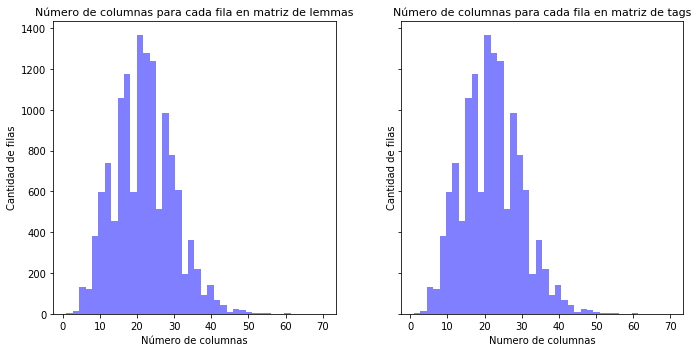

In [0]:
def largo_filas(matriz):
    tamanno_columnas = []
    for i in range(len(matriz)):
        tamanno_columnas.append(len(matriz[i]))
    return (tamanno_columnas)


np.random.seed(0)
num_bins = 40

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)

x_lemma = largo_filas(dataX)
x_tags = largo_filas(dataY)
ax0, ax1  = axes.flatten()

ax0.hist(x_lemma, num_bins, facecolor='blue', alpha=0.5)
ax0.set_xlabel("Número de columnas")
ax0.set_ylabel("Cantidad de filas")
ax0.set_title('Número de columnas para cada fila en matriz de lemmas', fontsize=11)


ax1.hist(x_tags, num_bins, facecolor='blue', alpha=0.5)
ax1.set_title('Número de columnas para cada fila en matriz de tags', fontsize=11)
ax1.set_xlabel("Numero de columnas")
ax1.set_ylabel("Cantidad de filas")

plt.ylabel("Cantidad de filas")
fig.tight_layout()

plt.show()

> b) Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.


In [0]:
def n_words(matrix):
    dic = dict()
    for i in range(len(matrix)):
        for word in matrix[i]:
            if word in dic:
                dic[word] += 1
            else:
                dic[word] = 0
    return (dic)

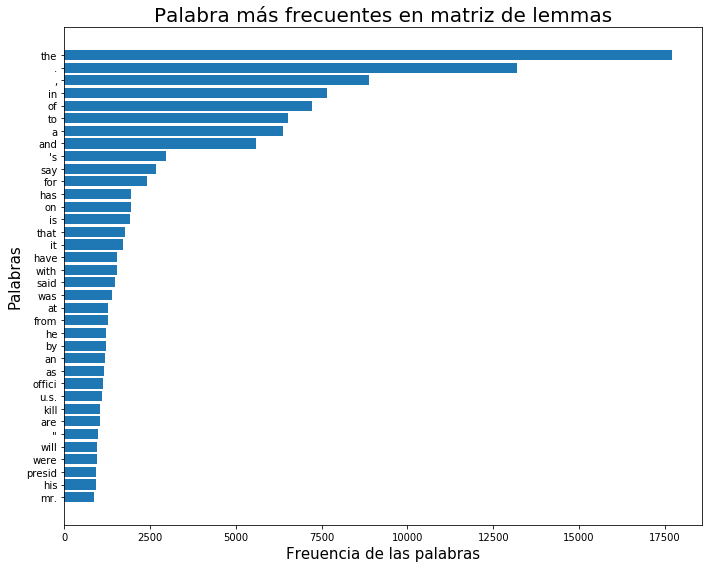

'\ntags = list(zip(*n_tags))[0][35::-1]\nfrec_tags = list(zip(*n_tags))[1][35::-1]\nx_pos_tags = np.arange(len(tags)) \n\n\nplt.figure(figsize=(10,8))\nplt.title("Tags más frecientes", fontsize =20)\nplt.barh(x_pos_tags, frec_tags,align=\'center\')\nplt.yticks(x_pos_tags, tags) \nplt.ylabel(\'Tags\', fontsize=15)\nplt.xlabel(\'Freciencia\', fontsize=15)\nplt.tight_layout()\nplt.show()\n'

In [0]:
n_lemma = sorted(n_words(dataX_raw).items(), key=operator.itemgetter(1), reverse=True)
n_tags = sorted(n_words(dataY_raw).items(), key=operator.itemgetter(1), reverse=True)


palabras = list(zip(*n_lemma))[0][35::-1]
frecuencia = list(zip(*n_lemma))[1][35::-1]
x_pos_lemma = np.arange(len(palabras))

plt.figure(figsize=(10,8))
plt.title("Palabra más frecuentes en matriz de lemmas", fontsize =20)
plt.barh(x_pos_lemma, frecuencia ,align='center')
plt.yticks(x_pos_lemma, palabras) 
plt.ylabel('Palabras', fontsize=15)
plt.xlabel('Freuencia de las palabras', fontsize=15)
plt.tight_layout()
plt.show()

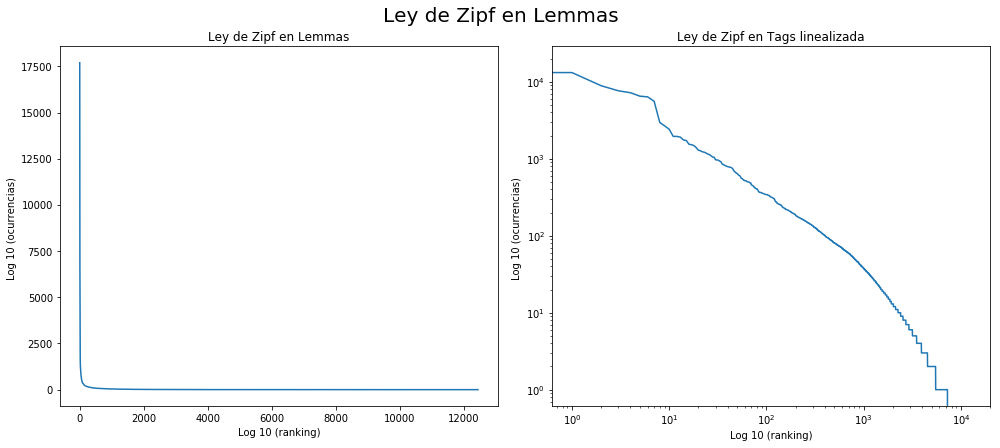

In [0]:
contador = 0
ranking = []
ocurrencias = []
for tupla in n_lemma:
    ranking.append(contador)
    contador+=1
    ocurrencias.append(tupla[1])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=False)


plt.suptitle("Ley de Zipf en Lemmas", y = 1.03, fontsize=20)


axes[0].set_title("Ley de Zipf en Lemmas")
axes[0].set_ylabel("Log 10 (ocurrencias) ")
axes[0].set_xlabel("Log 10 (ranking)")
axes[0].plot(ranking, ocurrencias)

axes[1].loglog(ranking, ocurrencias,basex=10)
axes[1].set_title("Ley de Zipf en Tags linealizada")
axes[1].set_ylabel("Log 10 (ocurrencias) ")
axes[1].set_xlabel("Log 10 (ranking)")


plt.tight_layout()

La ley Zipf propone que en una lengua la frecuencia de aparición de las palabras sigue una distribución aproximada como $P_{n} \sim \frac{1}{n^{a}}$, con $P_n$ la frecuencia de n-esima palabra más frecuente y $a$ aproximadamente 1, entonces la primera palabra tendría una frecuencia aproximada de $1/2$, el tercer elemento tendría una frecuencia de $1/3$ y así sucesivamente.

En nuestro caso, verificamos si esto se cumple para los 35 lemmas más frecuentes. Al linealizar la frecuencia de lemmas podemos ver que en efecto la ley se cumple pues se forma una curva rectilinea, además en el grafico sin linealizar se puede ver con claridad que ell comportamiento de la curva sigue lo esperado. 


> c) Para representar cada posible *tag* y *lemma* de modo que la red pueda manejarlo, será necesario codificarlos a un número único (*indice*) ¿Cuántos *tags* y *lemmas* distintos existen?  Comente sobre el significado del *tag* para cada *lemma*. **Finalmente mida el largo máximo de entre todas las sentencias**.
```python
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs
n_lemmas = len(lemmas)
lemma2idx = {w: i for i, w in enumerate(lemmas)} 
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs
```



In [0]:
def n_data(matriz):
    contador = 0
    for i in range(len(matriz)):
        contador+=len(matriz[i])
    return contador
print("cantidad de lemmas: ", n_data(dataX_raw))
print("cantidad de tags: ", n_data(dataY_raw))

cantidad de lemmas:  288995
cantidad de tags:  288995


In [0]:
len_max = 0
for i in range(len(dataX_raw)):
    if len(dataX_raw[i])>len_max:
        len_max = len(dataX_raw[i])
print("El maximo largo entre todas las sentencias es ", len_max)


El maximo largo entre todas las sentencias es  70


In [0]:
#Se agrega el nuevo caracter por comodidad para no volver a indexar en la pregunta futura
lemmas.add("endend")
labels.add("endend")

In [0]:
n_labels = len(labels)
n_lemmas = len(lemmas)

lab2idx = {t: i for i, t in enumerate(labels)}
lemma2idx = {w: i for i, w in enumerate(lemmas)}

dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs

print("existen", len(lab2idx)-1, "tags diferentes")
print("existen", len(lemma2idx)-1, "lemmas diferentes")

existen 17 tags diferentes
existen 12450 lemmas diferentes


> d) Debido a la distinta extensión de textos se deberá **realizar *padding* para estandarizar el largo**,
considere algun carácter especial **no presente en el vocabulario** para codificar el espacio en blanco en ambos (entrada y salida), por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un *lemma* que codificado significará el fin de la sentencia "the rocket *ENDPAD ENDPAD*" que codificado quedará como [32,4,*N, N*]. Decida, respecto al cómo funciona una red recurrente y su *memoria*, sobre qué le parece más conveniente al momento de rellenar con un valor especial ¿Al principio o al final de la sentencia? Comente
```python
lemma2idx["END"] = n_lemmas #add fullfill lemma and tag to the dictionary
lab2idx["END"] = n_labels
n_labels +=1
n_lemmas +=1
from keras.preprocessing import sequence
X = sequence.pad_sequences(dataX, maxlen=max_input_lenght,padding='pre' or 'post',value=lemma2idx["yourspecialcharacter"])
y = sequence.pad_sequences(dataY, maxlen=max_input_lenght,padding='pre' or 'post',value=lab2idx["endtagger"])
del dataY[:],dataX[:]
```



In [0]:
print("Largo dataX[0], Largo dataX[1], Largo dataX[2]: ", len(dataX[0]), len(dataX[1]), len(dataX[2]))


Largo dataX[0], Largo dataX[1], Largo dataX[2]:  30 14 15


In [0]:
lemmas_padding = sequence.pad_sequences(dataX,maxlen=len_max,padding='post', value=lemma2idx["endend"]) 
tags_padding = sequence.pad_sequences(dataY,maxlen=len_max,padding='post', value=lab2idx["endend"])

nn_lemmas = len(lemmas)
nn_labels = len(labels)
print("numero  lemmas (unicos): "+str(nn_lemmas))
print("numero de labels (unicos): "+str(nn_labels))


numero  lemmas (unicos): 12451
numero de labels (unicos): 18


In [0]:
print("El valor de lemma2idx['endend'] es :"+str(lemma2idx['endend']))
print("El valor de lab2idx['endend'] es :"+str(lab2idx['endend']))

El valor de lemma2idx['endend'] es :11233
El valor de lab2idx['endend'] es :12


In [0]:
print(lemmas_padding[0])
print(tags_padding[1])

[ 2114 10974  9839  6441  1568  6698  9539  5723  6698 12428 11527  4267
  5850  8392 11662 10548  1496  8204  8211  5210  9603   485  8204 10032
  8204  9803  6698  3091  3414  8204 11233 11233 11233 11233 11233 11233
 11233 11233 11233 11233 11233 11233 11233 11233 11233 11233 11233 11233
 11233 11233 11233 11233 11233 11233 11233 11233 11233 11233 11233 11233
 11233 11233 11233 11233 11233 11233 11233 11233 11233 11233]
[ 0  0  0  0  0  0  0  0  0  0  0  4  1  0 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12]


Para resolver el tema de la diferencia de largo en las filas se realiza post-pading. La razón de realizar post-pading no tiene mayor relevancia ya que no existe una gran diferencia si se realizaba pre-pading. Sin embargo por comodidad, se hizo post para asegurar que las oraciones esten siempre al inicio.

Se verificó el exitosamente la realización del padding

> e) Para poder generar una representación adecuada sobre los datos de entrada que permita realizar operaciones lineales, deberá generar una representación a un vector denso. Para ésto se utilizará la arquitectura de autoencoder **Word2Vec** [[2]](#refs) sobre textos *raws* de largo variable, en donde el *encoder* codifica una palabra categórica (*target*) a un vector denso de dimensionalidad $d$ mientras que el *decoder* genera palabras en el contexto (*context*) de la palabra *target* (en una vecindad alrededor). La idea detrás es que palabras similares sean proyectadas a una región cercana en el espacio de *embedding* ¿Cuál es la importancia del parámetro min_count? ¿Cuántos *lemmas* ve Word2Vec?
```python
from gensim.models import Word2Vec
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
min_count = 3
model = Word2Vec(dataX_raw,size=EMBEDDING_DIM,window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=min_count, negative=5,sg=1) #sg=1 mean skip-gram
embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}
len(embeddings_index.keys())
```
Genere una matriz de *embeddings* que se utilizarán como capa neuronal.
```python
embedding_matrix = np.zeros((n_lemmas, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector
```
Luego, para poder realizar una clasificación sobre los datos en la salida será necesario representarlos *one hot vectors*, esto resultará en un arreglo tridimensional.
```python
from keras.utils import to_categorical
y = np.asarray([to_categorical(i, num_classes=n_labels) for i in y])
```



In [0]:
EMBEDDING_DIM = 32
window_size = 5
nb_epoch = 5
batch_size = 6000
min_count = 3
ldataX_raw = list()
for i in dataX_raw:
    i = ldataX_raw.append(list(i))
model = Word2Vec(ldataX_raw,size=EMBEDDING_DIM,window=window_size,batch_words=batch_size,iter=nb_epoch,
                 min_count=min_count, negative=5,sg=1) #sg=1 mean skip-gram
embeddings_index = {vocab_word: model.wv[vocab_word] for vocab_word in model.wv.vocab}
len(embeddings_index.keys())

5485

In [0]:
frec_lemmas = list(zip(*n_lemma))[1]
a=0
for i in cia:
    if i>=3:
        a+=1

print(a)

4524


El parámetro min_count sirve para que el word2vect considere solo los lemmas con frecuencia mayor a 3, entonces word2vect vera en total 4524 lemmas de un total de 12451

In [0]:
embedding_matrix = np.zeros((nn_lemmas, EMBEDDING_DIM))
for word, i in lemma2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: #if word does not has embedding
        embedding_matrix[i] = embedding_vector

In [0]:
tags_padding.shape

(13233, 70)

In [0]:
tags_padding = np.asarray([to_categorical(i, num_classes=n_labels) for i in tags_padding])
tags_padding.shape

(13233, 70, 18)

> f) Luego de esto cree los conjuntos de entrenamiento y de prueba con el código a continuación **¿Cuáles son las dimensiones de entrada y salida de cada conjunto?** Comente
```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=22)
y_train.shape
```



In [0]:
X_train, X_test, y_train, y_test = train_test_split(lemmas_padding, tags_padding, test_size=0.3,random_state=22)

print("dimensiones de entrada")
print("X_train shape: "+str(X_train.shape))
print("y_train shape: "+str(y_train.shape))

print("dimensiones de salida")
print("X_test shape: "+str(X_test.shape))
print("y_test shape: "+str(y_test.shape))

dimensiones de entrada
X_train shape: (9263, 70)
y_train shape: (9263, 70, 18)
dimensiones de salida
X_test shape: (3970, 70)
y_test shape: (3970, 70, 18)



> g) Defina una red neuronal recurrente *many to many* con compuertas LSTM para aprender a *tagear* la entidad en el texto. Esta red debe procesar la secuencia de *lemmas* rellenados (o sin rellenar) y entregar el *tag* a cada uno de los *lemmas*, por lo que la salida de la red es una por cada instante de tiempo que se necesita entregar un *output*. La primera capa de la red a construir debe tener los vectores de *embedding* encontrados por **Word2Vec**. **Comente sobre los cambios que sufre un dato al ingresar a la red y la cantidad de parámetros de la red**. Entrene y luego evalúe su desempeño sobre ambos conjuntos. 
```python
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout,TimeDistributed
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=max_input_lenght,
                    trainable=False, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(n_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)
```
Para evaluar su modelo utilice una métrica adecuada para el desbalance presente entre las clases como identificó en el punto b). Tenga presente en este punto el **no evaluar** la clase/símbolo que añadió para realizar *padding* a los *tag*.  
*Hint: podría "truncar" la salida predicha hasta el largo real de esa sentencia*.
```python
from sklearn.metrics import f1_score
dataY_pred = model.predict_classes(X_test,verbose=0) #process... to remove prediction on "endtagger" symbol
f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(dataY,dataY_pred) ]
print("F1 score on test: ", np.mean(f1_score_bydata) )
```



In [0]:
model = Sequential()
model.add(Embedding(input_dim=nn_lemmas, output_dim=EMBEDDING_DIM, input_length=len_max,
                    trainable=False, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(nn_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 70, 32)            398432    
_________________________________________________________________
lstm_6 (LSTM)                (None, 70, 100)           53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 70, 18)            1818      
Total params: 453,450
Trainable params: 55,018
Non-trainable params: 398,432
_________________________________________________________________
Train on 9263 samples, validate on 3970 samples
Epoch 1/15
9263/9263 [==============================] - 16s 2ms/step - loss: 0.8542 - acc: 0.8037 - val_loss: 0.3279 - val_acc: 0.9376
Epoch 2/15
9263/9263 [==============================] - 14s 2ms/step - loss: 0.2

Con un total de 453450, solo 55018 de ellos fieron entrenados. De todos los parametros 398432 fueron usados en la capa embedding, 53200 en la capa lstm y 18181 en la ultima capa

El shape de la capa de embedding está dado por (None, 70, 32) con 70 el máximo número de columnas y 32 el embedding utilizado. La capa LSTM, tiene una forma de (None, 70, 100). 

La ultima capa tiene el shape (None, 70, 18)  y el ultimo valor corresponde a la salida (solo hay 18 opciones de post tags).

Al evaluar la función con f1_score, se generaron varios conflictos que no fue posible resolver, es por esto que la evaluación del modelo se hará a partir de otra métrica

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("La perdida del modelo es de: ", scores[0], "y el accuracy es de: ", scores[1])

La perdida del modelo es de:  0.12540326876288999 y el accuracy es de:  0.9665095339794303


Se alcanza un buen resultado al obtener un exactiud del 96%

In [0]:
#y_test_2 =np.argmax(y_test, axis=2)
#dataY_pred = model.predict(np.array(y_test_2))

In [0]:
#f1_score_bydata = [f1_score(true, pred ,average='macro') for true,pred in zip(y_test,dataY_pred) ]
#print("F1 score on test: ", np.mean(f1_score_bydata) )

> h) Varíe con seguir entrenando la capa de embedding seteada al definir la arquitectura, ésto es cambiar a *trainable=True*, compare el desempeño y el número de parámetros (entrenables) con lo anterior. Comente



In [0]:
model = Sequential()
model.add(Embedding(input_dim=nn_lemmas, output_dim=EMBEDDING_DIM, input_length=len_max,
                    trainable=True, weights = [embedding_matrix]))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(nn_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 70, 32)            398432    
_________________________________________________________________
lstm_7 (LSTM)                (None, 70, 100)           53200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 70, 18)            1818      
Total params: 453,450
Trainable params: 453,450
Non-trainable params: 0
_________________________________________________________________
Train on 9263 samples, validate on 3970 samples
Epoch 1/5
9263/9263 [==============================] - 17s 2ms/step - loss: 0.8411 - acc: 0.8927 - val_loss: 0.3085 - val_acc: 0.9404
Epoch 2/5
9263/9263 [==============================] - 15s 2ms/step - loss: 0.2777 - a

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("La perdida del modelo es de: ", scores[0], "y el accuracy es de: ", scores[1])

La perdida del modelo es de:  0.13377723860875784 y el accuracy es de:  0.9642533337739613


Aquí se logran entrenar todos los parámetros,  pero el desempeño es levemente peor, pero la diferencia es insignificante.

> i) Experimente con cambiar la *gate* de recurrencia a una con menos parámetros pero que mantiene la capacidad de memoria de la LSTM, ésta es la compuerta GRU. Comente sobre los resultados esperados y observados.
```python
from keras.layers import GRU
...
model.add(GRU(units=100,return_sequences=True))
...
```



In [0]:
from keras.layers import GRU

model = Sequential()
model.add(Embedding(input_dim=nn_lemmas, output_dim=EMBEDDING_DIM, input_length=len_max,
                    trainable=True, weights = [embedding_matrix]))
model.add(GRU(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(nn_labels, activation='softmax')))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=128)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 70, 32)            398432    
_________________________________________________________________
gru_3 (GRU)                  (None, 70, 100)           39900     
_________________________________________________________________
dropout_8 (Dropout)          (None, 70, 100)           0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 70, 18)            1818      
Total params: 440,150
Trainable params: 440,150
Non-trainable params: 0
_________________________________________________________________
Train on 9263 samples, validate on 3970 samples
Epoch 1/15
9263/9263 [==============================] - 15s 2ms/step - loss: 1.0151 - acc: 0.8958 - val_loss: 0.2719 - val_acc: 0.9448
Epoch 2/15
9263/9263 [==============================] - 13s 1ms/step - loss: 0.2430 -

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("La perdida del modelo es de: ", scores[0], "y el accuracy es de: ", scores[1])

La perdida del modelo es de:  0.06267763042930391 y el accuracy es de:  0.9825440786347281


Usando GRU existe un cambio en la evaluación del modelo, el accuracy es mayor y la perdida a su vez es menor.

> j) Algunos autores señalan la importante dependencia que existe en texto, no solo con las palabras anteriores, sino que con las que siguen. Mejore la red utilizando una red neuronal recurrente Bidireccional, es decir, con recurrencia en ambas direcciones sobre la secuencia de *lemmas*. Comente cuál debiera ser la forma correcta de usar el parámetro merge_mode (concatenar, multiplicar, sumar o promediar) para este caso. Además comente las transformaciones que sufre el patrón de entrada al pasar por las capas. ¿Mejora o empeora el desempeño? Analice.
```python
from keras.layers import Bidirectional
...
gate_layer = (LSTM or GRU )(units=100,return_sequences=True)
model.add(Bidirectional(gate_layer, merge_mode=choose))
...
```



Las redes bidireccionales "miran" hacía adelante y hacía atrás, este tipo de red es muy útil cuando el contexto es importante en un problema, por ejemplo en la traducción. El merge_mode combina las salidas de adelante y de atrás, dado que anteriormente se consiguió mejor resultado usando GRU, mantendremos esta arquitectura para probar los merge_mode.

In [0]:
from datetime import datetime

merge_mode_array = ['sum', 'mul', 'concat', 'ave']
start_time = datetime.now()
scores_merge_mode_array = []
scores_merge_mode_array_evaluate = []
epoch_anterior_time = datetime.now()

for mode in merge_mode_array:  
    model = Sequential()
    model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=len_max))
    layer_gru = GRU(units=100,return_sequences=True)
    model.add(Bidirectional(layer_gru,merge_mode=mode))
    model.add(Dense(n_labels, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    scores_merge_mode =model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128)
    scores_merge_mode_array.append((mode,scores_merge_mode))
    scores_merge_mode_array_evaluate.append((mode,model.evaluate(X_test, y_test, verbose=0)))
    end_time = datetime.now()
    print('Duracion en Mode '+str(mode)+' : {}'.format(end_time - epoch_anterior_time))
    epoch_anterior_time = datetime.now()
end_time = datetime.now()
print('Duracion Final: {}'.format(end_time - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 70, 32)            398432    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 70, 100)           79800     
_________________________________________________________________
dense_14 (Dense)             (None, 70, 18)            1818      
Total params: 480,050
Trainable params: 480,050
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 9263 samples, validate on 3970 samples
Epoch 1/3
9263/9263 [==============================] - 27s 3ms/step - loss: 0.9922 - acc: 0.8186 - val_loss: 0.2921 - val_acc: 0.9508
Epoch 2/3
9263/9263 [==============================] - 21s 2ms/step - loss: 0.2403 - acc: 0.9523 - val_loss: 0.2113 - val_acc: 0.9515
Epoch 3/3
9263/9263 [==============================] - 21s 2ms/step - loss: 0.1739 - acc: 0.9539 - val_loss: 0.1522 - val_acc: 0.9582
Duracion en Mode sum : 0:01:14.469189
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 70, 32)            398432    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 70, 100)           79800     
_________________________________________________________________
dense_15 (Dense)             (None, 70, 18)            1818      
Total params: 480,050
Trainable params: 480,050
No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 9263 samples, validate on 3970 samples
Epoch 1/3
9263/9263 [==============================] - 26s 3ms/step - loss: 1.4392 - acc: 0.7227 - val_loss: 0.5720 - val_acc: 0.9222
Epoch 2/3
9263/9263 [==============================] - 21s 2ms/step - loss: 0.3799 - acc: 0.9429 - val_loss: 0.2932 - val_acc: 0.9504
Epoch 3/3
9263/9263 [==============================] - 21s 2ms/step - loss: 0.2474 - acc: 0.9523 - val_loss: 0.2214 - val_acc: 0.9515
Duracion en Mode mul : 0:01:13.435059
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 70, 32)            398432    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 70, 200)           79800     
_________________________________________________________________
dense_16 (Dense)             (None, 70, 18)            3618      
Total params: 481,850
Trainable params: 481,850
No

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 9263 samples, validate on 3970 samples
Epoch 1/3
9263/9263 [==============================] - 27s 3ms/step - loss: 0.9901 - acc: 0.8096 - val_loss: 0.3006 - val_acc: 0.9428
Epoch 2/3
9263/9263 [==============================] - 22s 2ms/step - loss: 0.2524 - acc: 0.9495 - val_loss: 0.2272 - val_acc: 0.9511
Epoch 3/3
9263/9263 [==============================] - 22s 2ms/step - loss: 0.1913 - acc: 0.9528 - val_loss: 0.1649 - val_acc: 0.9535
Duracion en Mode concat : 0:01:15.363792
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 70, 32)            398432    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 70, 100)           79800     
_________________________________________________________________
dense_17 (Dense)             (None, 70, 18)            1818      
Total params: 480,050
Trainable params: 480,050

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 9263 samples, validate on 3970 samples
Epoch 1/3
9263/9263 [==============================] - 27s 3ms/step - loss: 1.1456 - acc: 0.7630 - val_loss: 0.3566 - val_acc: 0.9406
Epoch 2/3
9263/9263 [==============================] - 21s 2ms/step - loss: 0.2856 - acc: 0.9458 - val_loss: 0.2605 - val_acc: 0.9514
Epoch 3/3
9263/9263 [==============================] - 21s 2ms/step - loss: 0.2425 - acc: 0.9524 - val_loss: 0.2374 - val_acc: 0.9514
Duracion en Mode ave : 0:01:14.360205
Duracion Final: 0:04:57.629695


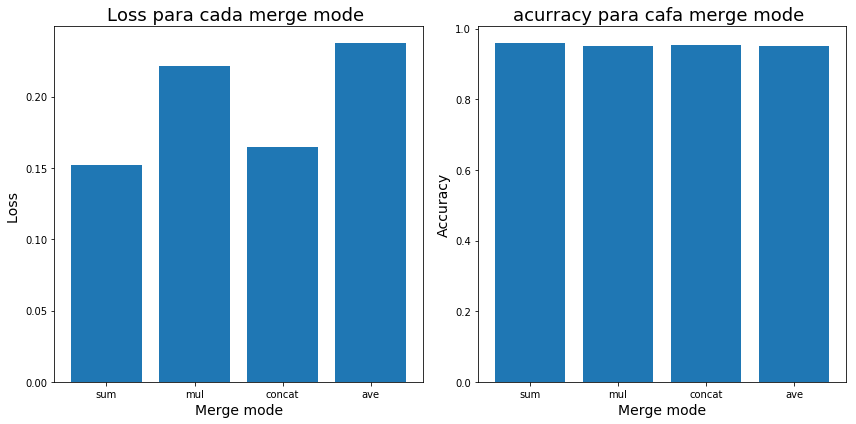

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=False)

loss_array = []
accuracy_array = []

for i in range(len(scores_merge_mode_array_evaluate)):
    loss_array.append(scores_merge_mode_array_evaluate[i][1][0])
    accuracy_array.append(scores_merge_mode_array_evaluate[i][1][1])


axes[0].bar([0,1,2,3], loss_array)

axes[0].set_title('Loss para cada merge mode ',fontsize=18)
axes[0].set_ylabel("Loss ", fontsize=14)
axes[0].set_xlabel("Merge mode", fontsize=14)
axes[0].set_xticks((0,1,2,3))
axes[0].set_xticklabels(('sum','mul','concat','ave'))

axes[1].bar([0,1,2,3], accuracy_array)
axes[1].set_title('acurracy para cafa merge mode ', fontsize=18)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Merge mode", fontsize=14)
axes[1].set_xticks((0,1,2,3))
axes[1].set_xticklabels(['sum','mul','concat','ave'])

plt.tight_layout()

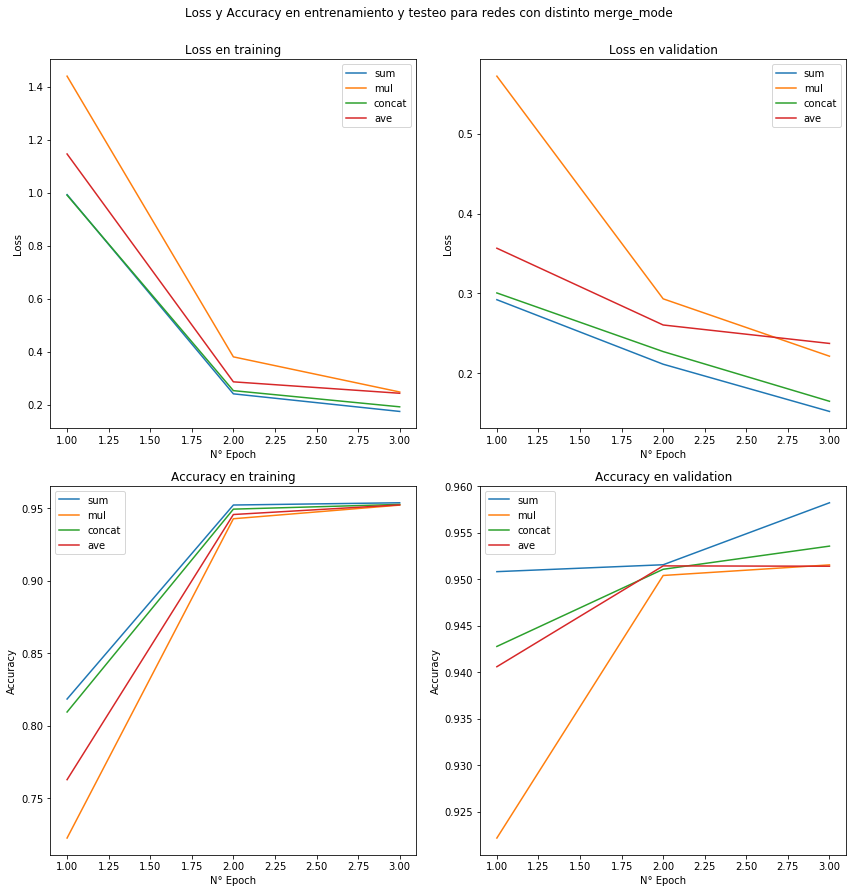

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12,12))
ax = axes.flatten()

for i in range(len(scores_merge_mode_array)):
    ax[0].plot(range(1,4),scores_merge_mode_array[i][1].history['loss'], label=scores_merge_mode_array[i][0])
    ax[1].plot(range(1,4),scores_merge_mode_array[i][1].history['val_loss'], label=scores_merge_mode_array[i][0])
    ax[2].plot(range(1,4),scores_merge_mode_array[i][1].history['acc'], label=scores_merge_mode_array[i][0])
    ax[3].plot(range(1,4),scores_merge_mode_array[i][1].history['val_acc'], label=scores_merge_mode_array[i][0])

    
ax[0].set_title('Loss en el entrenamiento')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('N° Epoch')
ax[0].legend()
ax[1].set_title('Loss en en la validación')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('N° Epoch')
ax[1].legend()
ax[2].set_title('Accuracy en el entrenamiento')
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('N° Epoch')
ax[2].legend()
ax[3].set_title('Accuracy en la validación')
ax[3].set_ylabel('Accuracy')
ax[3].set_xlabel('N° Epoch')
ax[3].legend()
plt.suptitle("Loss y Accuracy en entrenamiento y testeo para redes con distinto merge_mode", y=1.03)
plt.tight_layout()
plt.show()

Si bien nuestra lógico nos hace pensar que los mejores merge_mode deberían ser sum o concat, los resultados indican que la multiplicación es el mejor resultado. Sin embardo en el entrenamiento, sum es el que tiene mejor resultado.

> l) Utilice la red con mejor desempeño encontrada, idealmente la encontrada en (j), y **muestre las predicciones** del *NER tager*, sobre algún ejemplo de pruebas, comente.  
```python
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(lemmas[w],labels[pred]))
```

Se decide usar la red con mejor desempeño en (j), una red bidireccional con mul en merge_mode.

In [0]:
model = Sequential()
model.add(Embedding(input_dim=n_lemmas, output_dim=EMBEDDING_DIM, input_length=len_max))
layer_gru = GRU(units=100,return_sequences=True)
model.add(Bidirectional(layer_gru,merge_mode='mul'))
model.add(Dense(n_labels, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score_merge_mode =model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=128)
score=mode,model.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 70, 32)            398432    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 70, 100)           79800     
_________________________________________________________________
dense_18 (Dense)             (None, 70, 18)            1818      
Total params: 480,050
Trainable params: 480,050
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 9263 samples, validate on 3970 samples
Epoch 1/3
9263/9263 [==============================] - 28s 3ms/step - loss: 1.4639 - acc: 0.7080 - val_loss: 0.6192 - val_acc: 0.8540
Epoch 2/3
9263/9263 [==============================] - 21s 2ms/step - loss: 0.4030 - acc: 0.9379 - val_loss: 0.2993 - val_acc: 0.9501
Epoch 3/3
9263/9263 [==============================] - 21s 2ms/step - loss: 0.2551 - acc: 0.9520 - val_loss: 0.2299 - val_acc: 0.9514


In [0]:
p = model.predict(np.array([X_test[0]]))
p = np.argmax(p, axis=-1)
print("{:15}: {}".format("Lemma", "Pred"))
lab2idx_invertido = {v: k for k, v in lab2idx.items()}
lemma2idx_invertido = {v: k for k, v in lemma2idx.items()}
for w,pred in zip(X_test[0],p[0]):
    print("{:15}: {}".format(lemma2idx_invertido[w],lab2idx_invertido[pred]))

Lemma          : Pred
sinc           : O
2005           : O
,              : O
the            : O
govern         : O
has            : O
re-nation      : O
a              : O
number         : O
of             : O
privat         : O
compani        : O
.              : O
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend         : endend
endend     